In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [1]:
df = pd.read_csv('sorting_event_volumes_2023.csv')

In [2]:
# Data cleaning
print("Number of rows is: " + str(df.shape[0]))

df = df.loc[df["event_type"] == "LAJ", :]
df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
df.dropna(inplace = True)
df['output_belt'] = df['output_belt'].astype(int)
df['scanning_date'] = pd.to_datetime(df['scanning_date'])

print("Number of rows cleaned data is: " + str(df.shape[0]))

Number of rows is: 8949721
Number of rows cleaned data is: 7450939


In [3]:
# Data preparation
df['day'] = df['scanning_date'].dt.day
df['month'] = df['scanning_date'].dt.month
df['weekday'] = df['scanning_date'].dt.day_of_week + 1
df['week'] = df['scanning_date'].dt.day_of_year // 7 + 1

sorting_center_names = df["sorting_center_name"].unique()
df["sorting_center_name"].value_counts()

sorting_center_name
VANTAA       4888466
TAMPERE      1154436
KUOPIO        578274
LIETO         443087
OULU          354047
SEINÄJOKI      32629
Name: count, dtype: int64

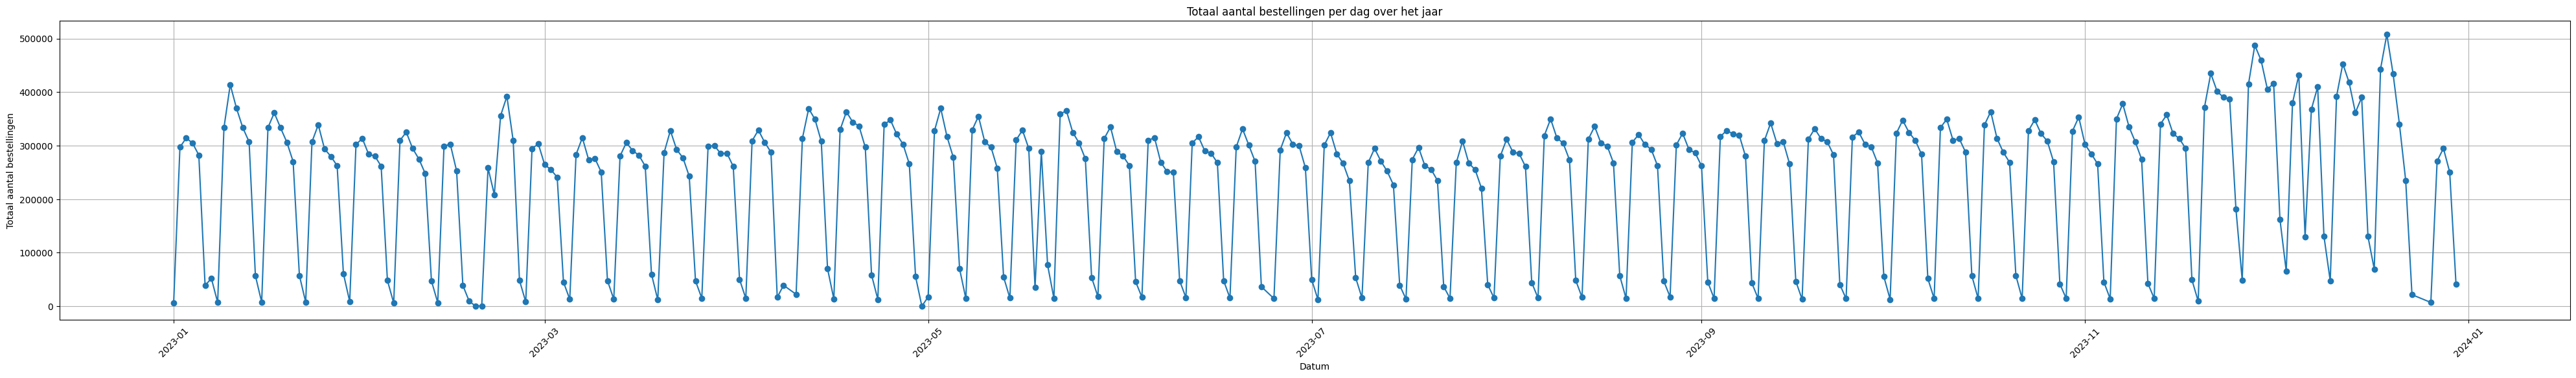

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def total_orders_per_day(df):
    daily_totals = df.groupby('scanning_date')['no_of_events'].sum()

    plt.figure(figsize=(50, 6))
    plt.plot(daily_totals.index, daily_totals.values, marker='o')
    plt.xlabel('Datum')
    plt.ylabel('Totaal aantal bestellingen')
    plt.title('Totaal aantal bestellingen per dag over het jaar')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

total_orders_per_day(df)


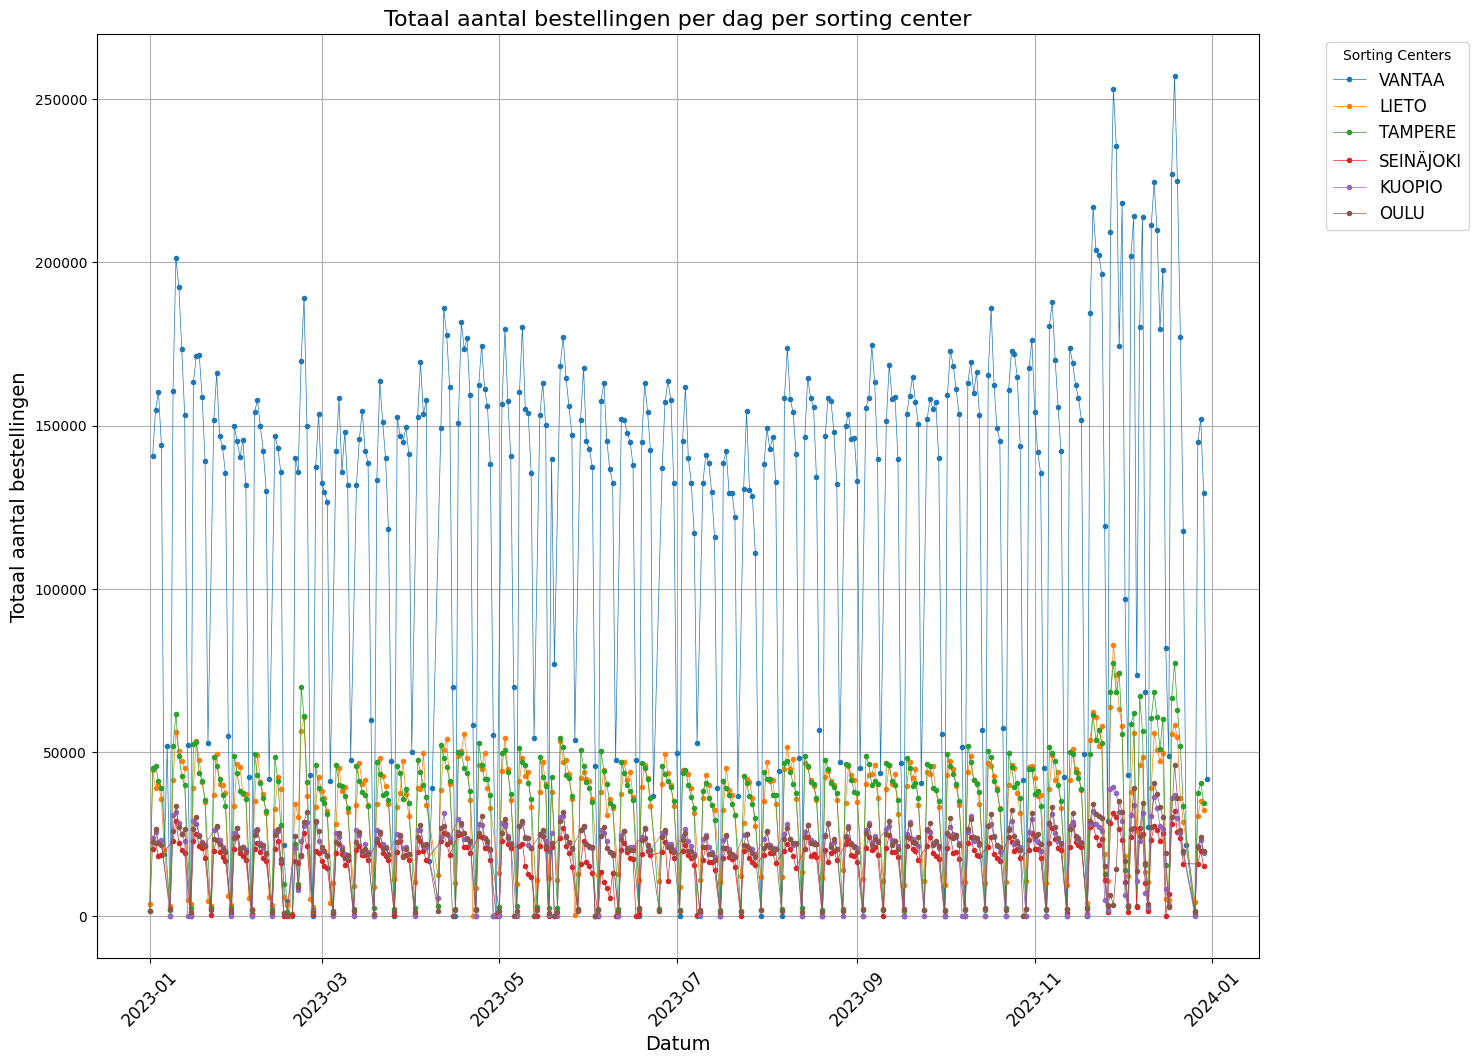

In [20]:
def total_orders_per_day_by_center(df):
    centers = df['sorting_center_name'].unique()
    
    plt.figure(figsize=(15, 12))
    
    for center in centers:
        daily_totals = df[df['sorting_center_name'] == center].groupby('scanning_date')['no_of_events'].sum()
        plt.plot(daily_totals.index, daily_totals.values, marker='.', label=center, linewidth=0.5)  # Pas de dikte van de lijn aan

    plt.xlabel('Datum', fontsize=14)  # Pas de lettergrootte voor de x-as aan
    plt.ylabel('Totaal aantal bestellingen', fontsize=14)  # Pas de lettergrootte voor de y-as aan
    plt.title('Totaal aantal bestellingen per dag per sorting center', fontsize=16)  # Pas de lettergrootte voor de titel aan
    plt.xticks(rotation=45, fontsize=12)  # Pas de lettergrootte voor de x-as tick labels aan
    plt.legend(title='Sorting Centers', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)  # Pas de lettergrootte voor de legende aan
    plt.grid(True)
    plt.show()

total_orders_per_day_by_center(df)



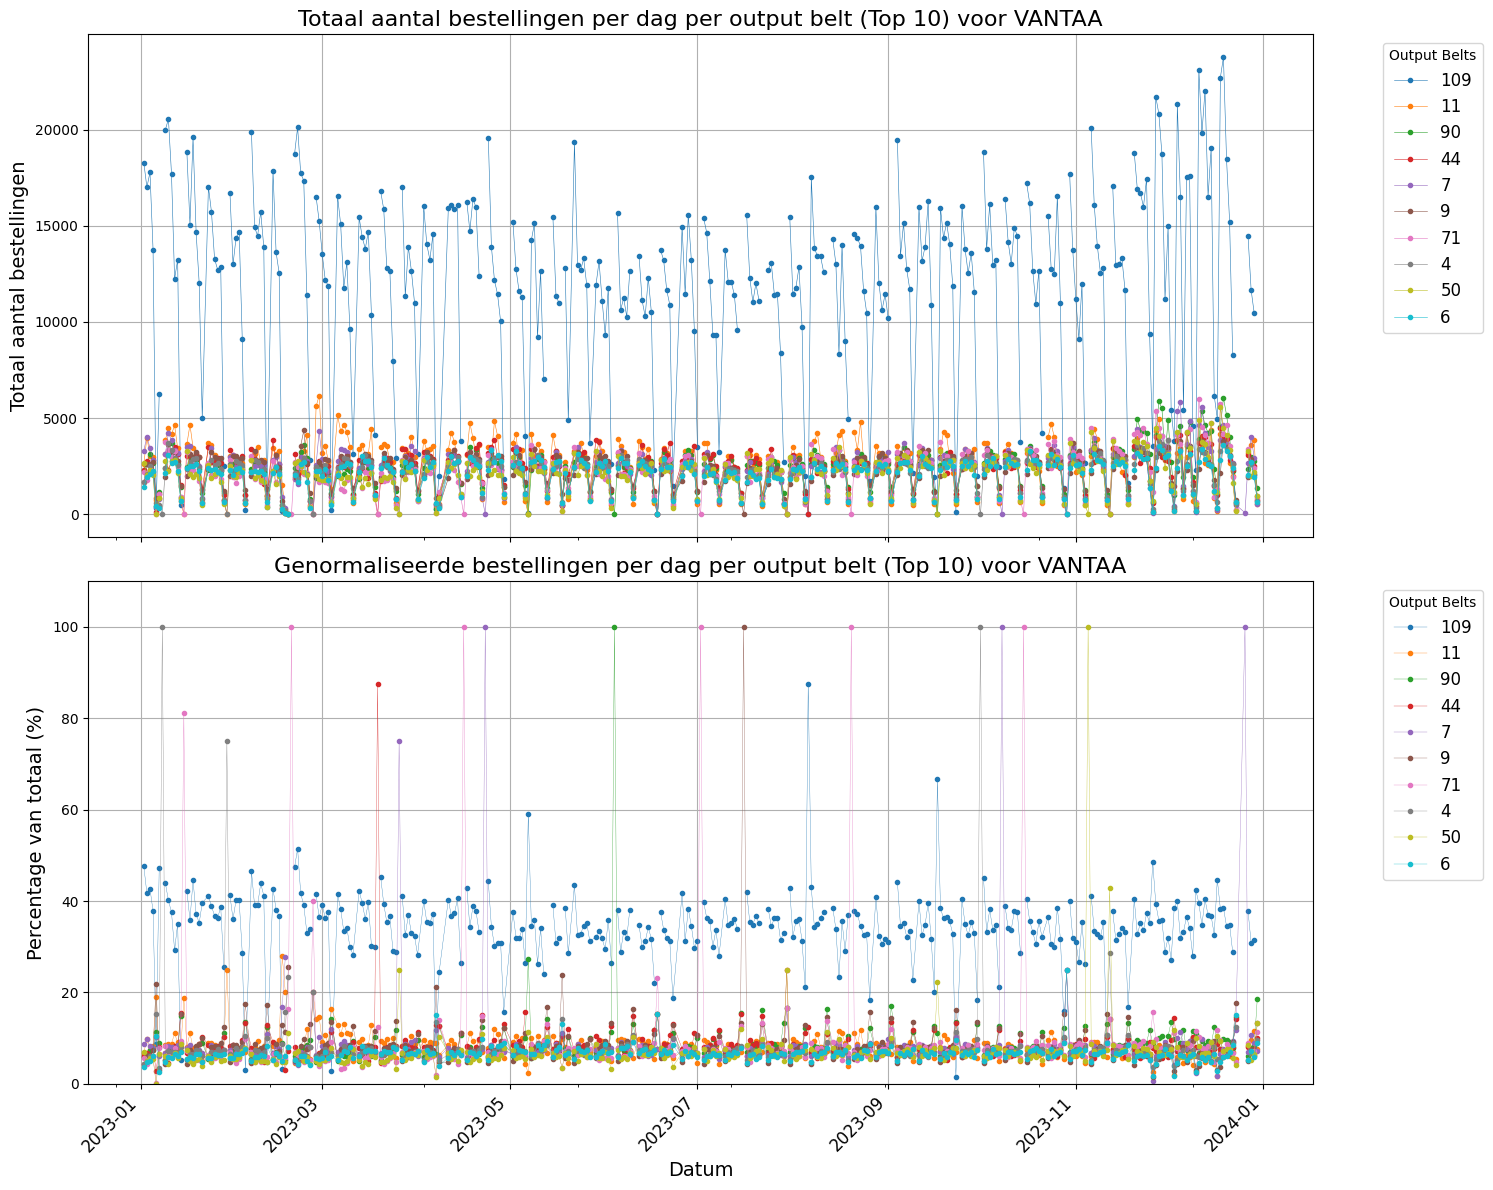

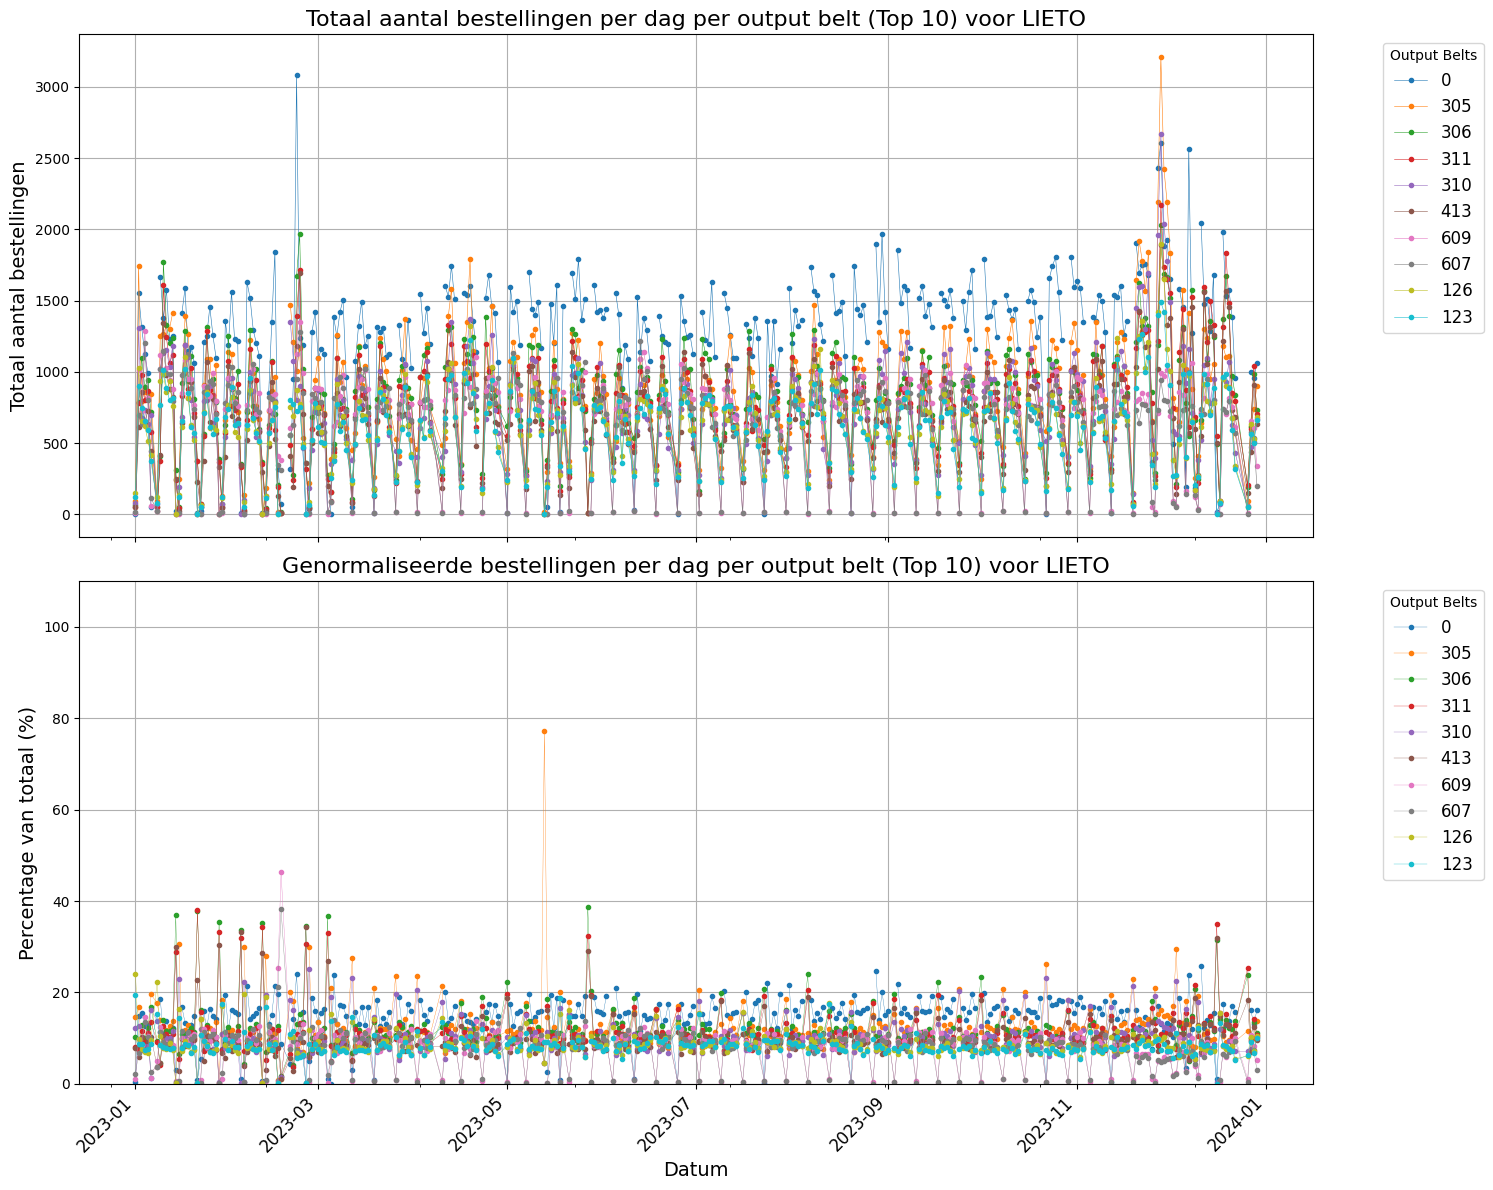

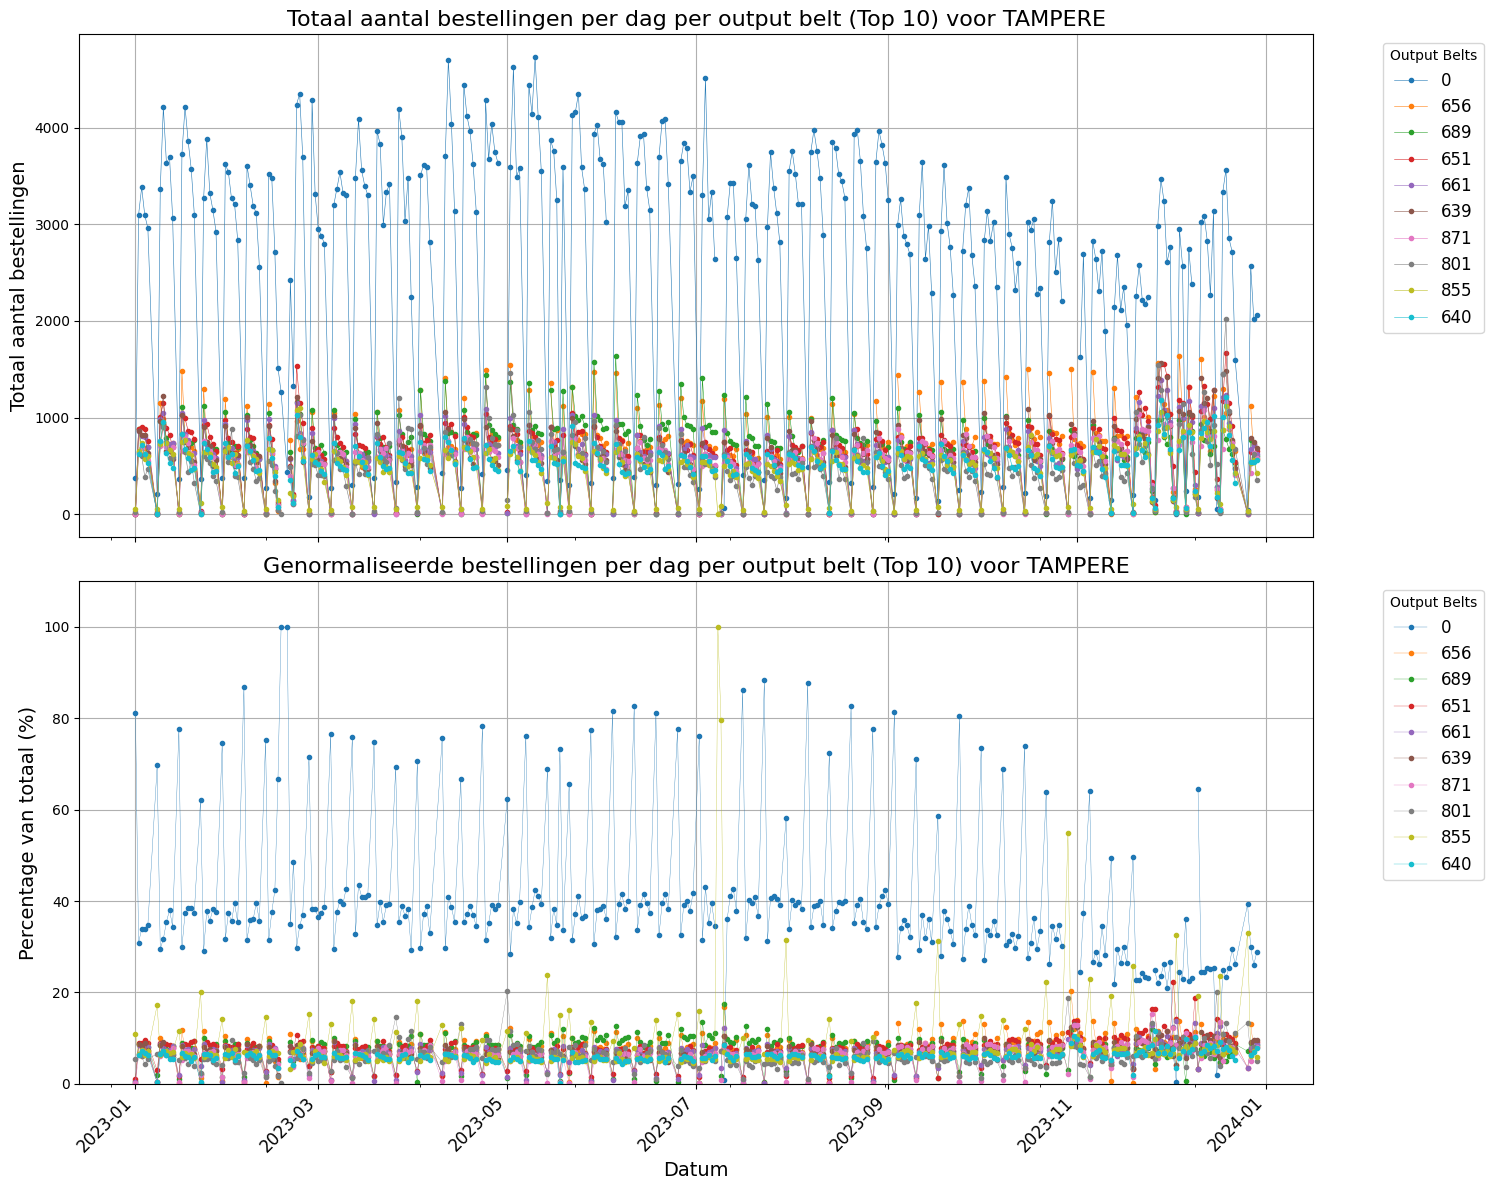

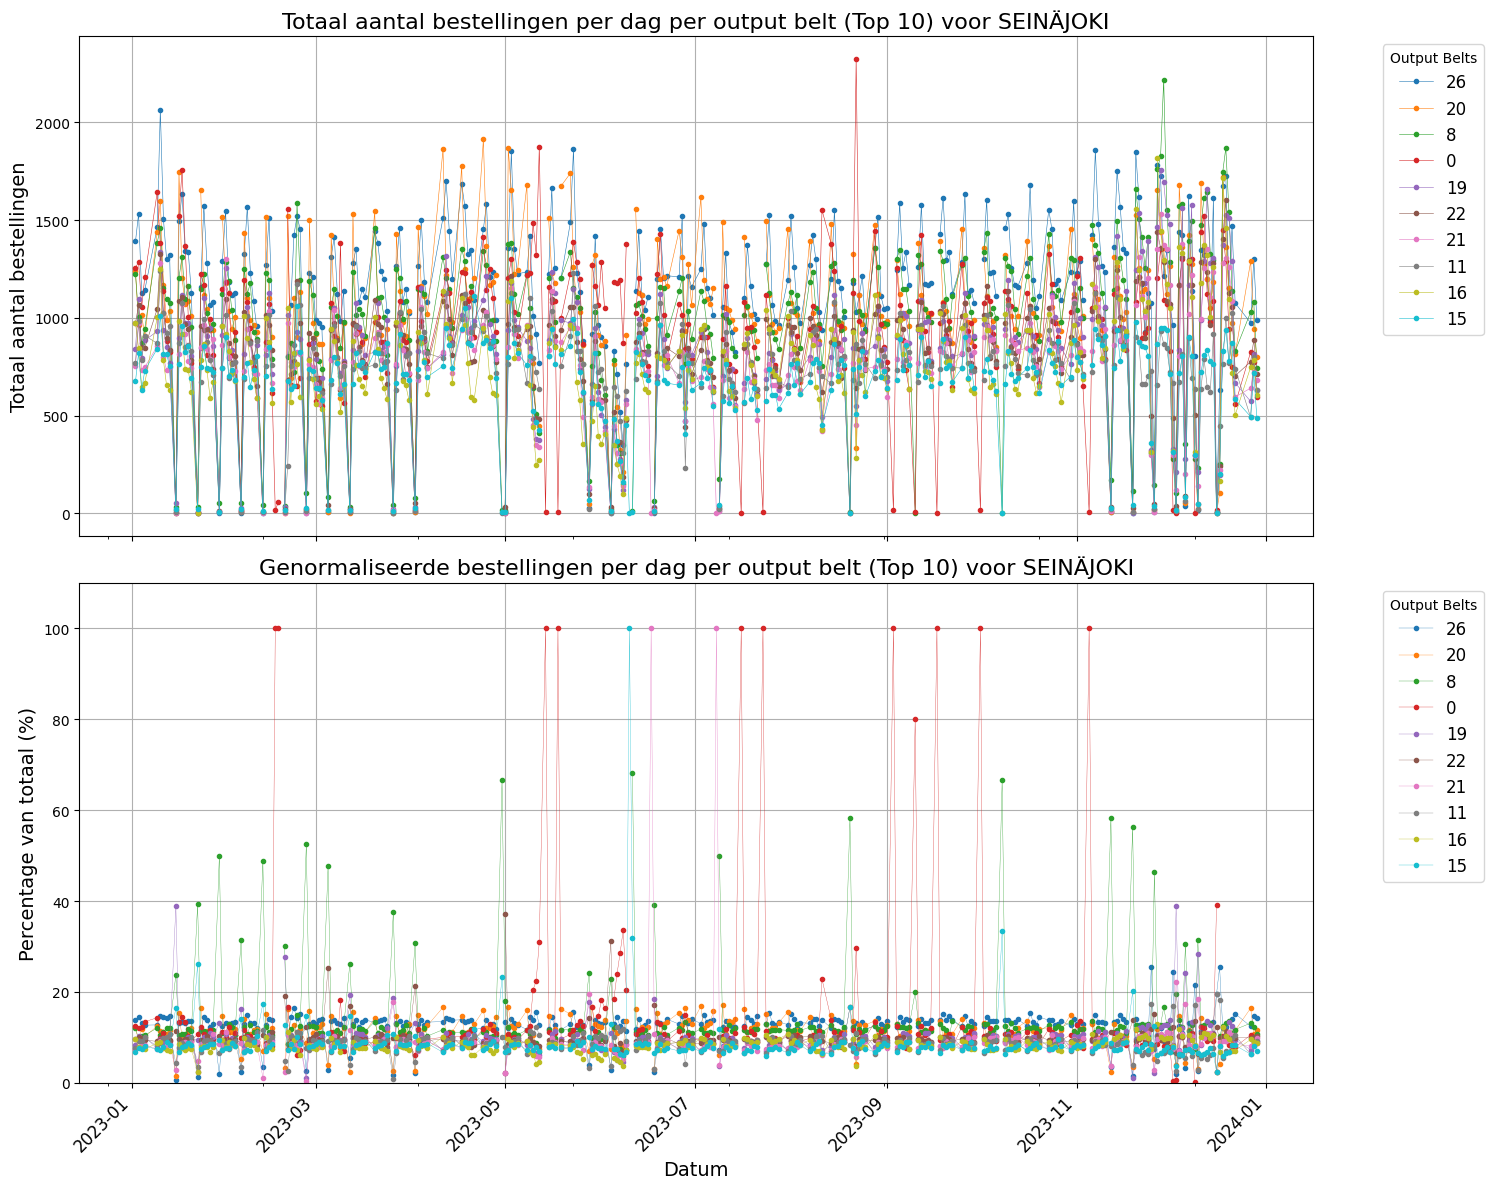

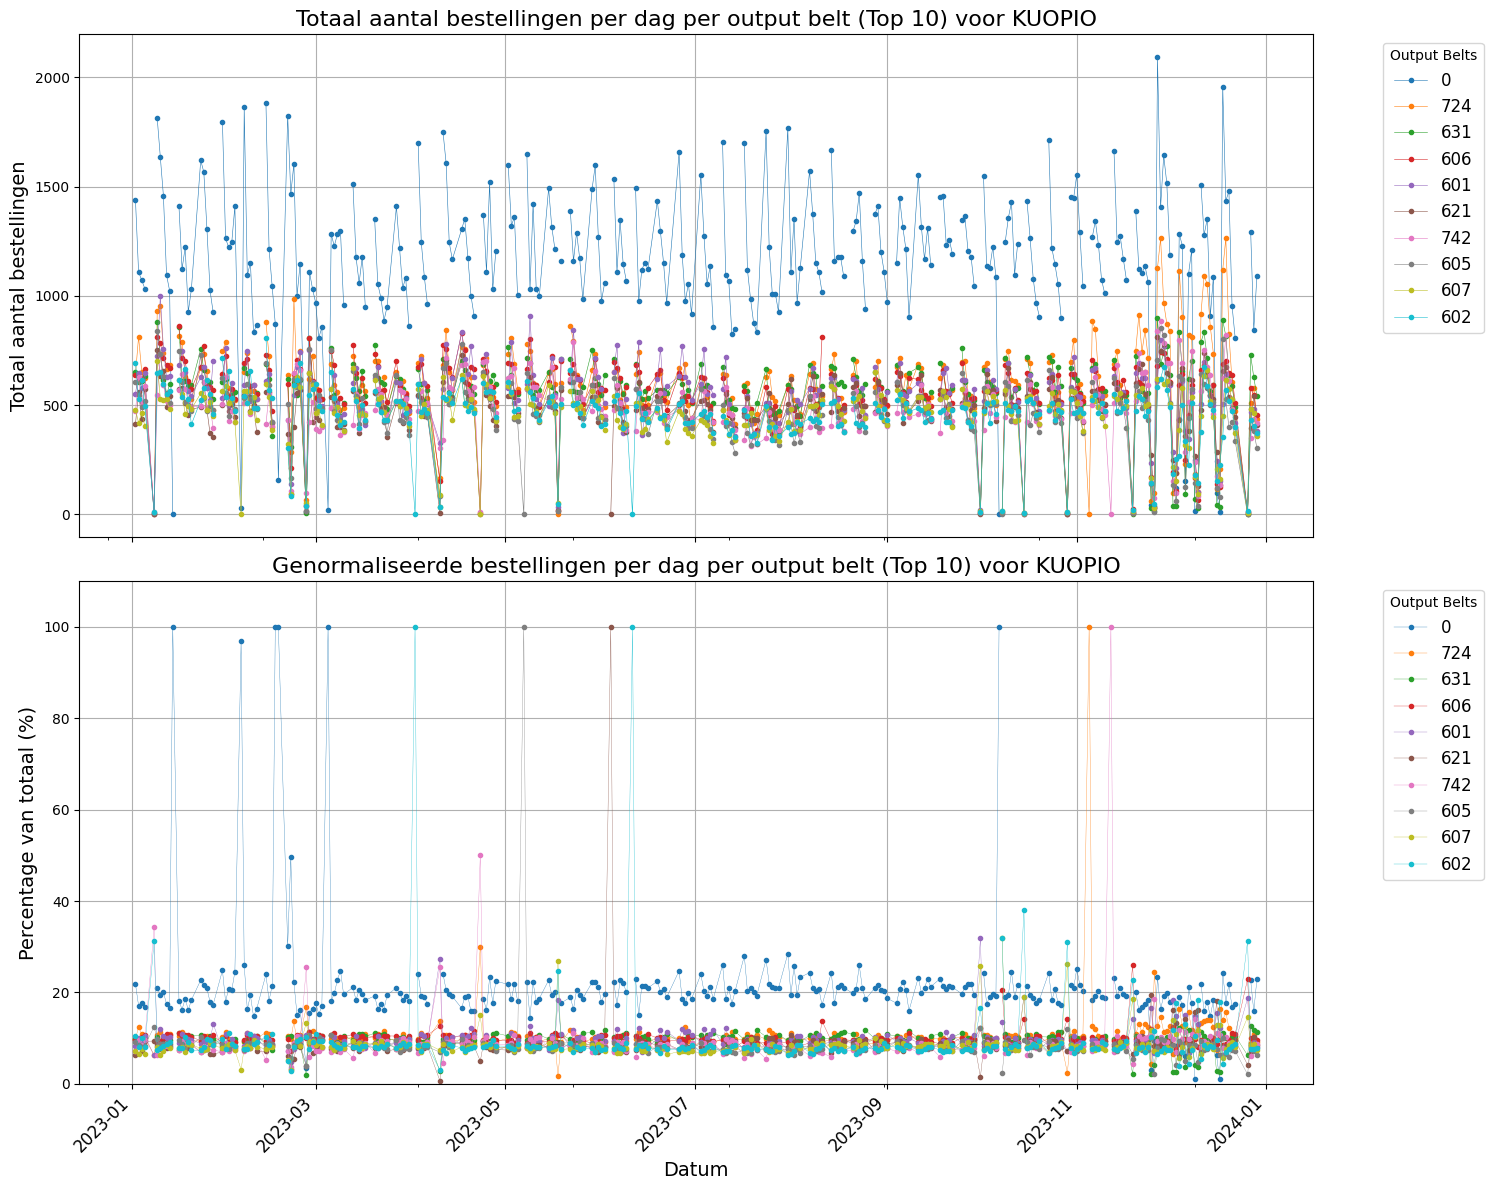

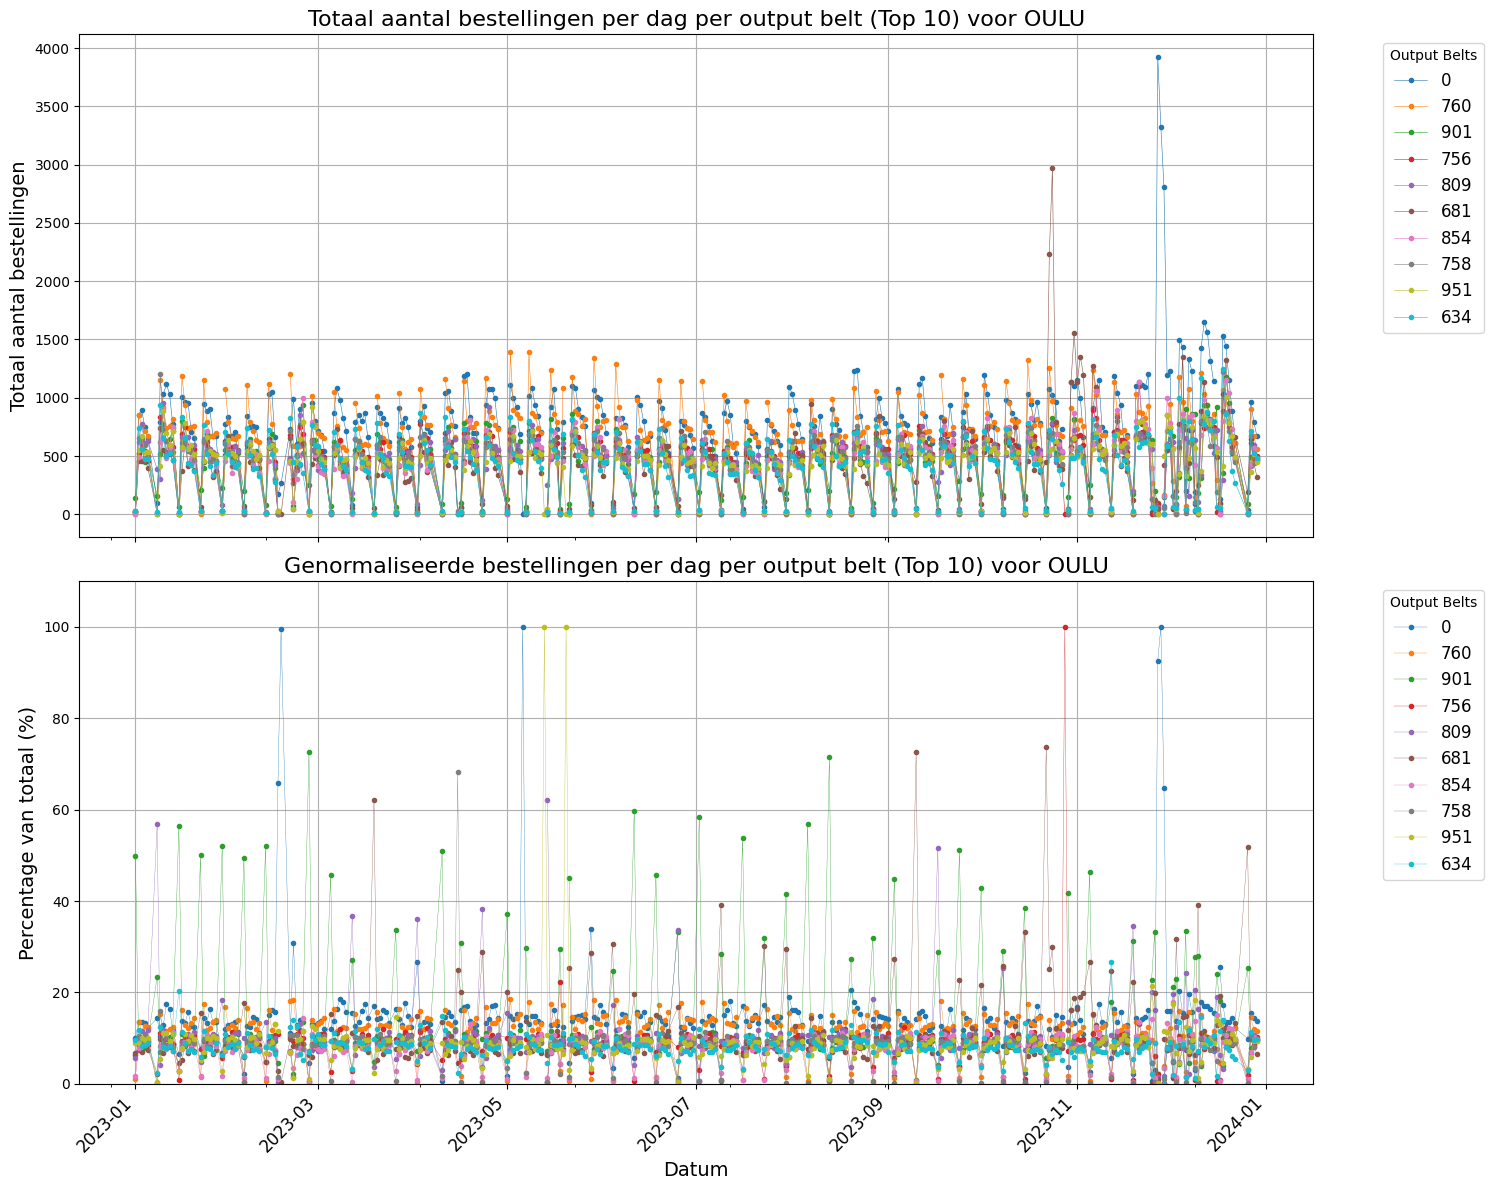

In [67]:
def output_sums_and_normalized_per_day_by_belt(df, sorting_center_name, top_x=100):
    # Berekening van de dagelijkse totalen per output belt
    daily_totals = df[df['sorting_center_name'] == sorting_center_name].groupby(['scanning_date', 'output_belt'])['no_of_events'].sum().unstack()

    # Sorteren van de output belts op basis van het totale aantal bestellingen en selecteren van de top_x
    total_per_belt = daily_totals.sum().sort_values(ascending=False)
    top_belts = total_per_belt.head(top_x).index  # Selecteer de top_x output belts

    # Beperk de data tot de top_x output belts
    daily_totals_top = daily_totals[top_belts]

    # Berekening van de genormaliseerde percentages voor de top_x output belts
    daily_totals_normalized = daily_totals_top.div(daily_totals_top.sum(axis=1), axis=0) * 100

    # Filter dagen met een totaal aantal bestellingen lager dan een drempel (bijvoorbeeld 2000)
    daily_totals_normalized = daily_totals_normalized[daily_totals_top.sum(axis=1) > 0]

    # Creëer een figuur met 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

    # Plot voor absolute aantallen
    daily_totals_top.plot(ax=ax1, marker='.', linewidth=0.4)  # Geen lijnen, alleen markers
    ax1.set_xlabel('')
    ax1.set_ylabel('Totaal aantal bestellingen', fontsize=14)
    ax1.set_title(f'Totaal aantal bestellingen per dag per output belt (Top {top_x}) voor {sorting_center_name}', fontsize=16)
    ax1.tick_params(axis='x', rotation=45, labelsize=12)
    ax1.legend(title='Output Belts', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax1.grid(True)

    # Plot voor genormaliseerde percentages
    daily_totals_normalized.plot(ax=ax2, marker='.', linewidth=0.24)  # Geen lijnen, alleen markers
    ax2.set_xlabel('Datum', fontsize=14)
    ax2.set_ylabel('Percentage van totaal (%)', fontsize=14)
    ax2.set_title(f'Genormaliseerde bestellingen per dag per output belt (Top {top_x}) voor {sorting_center_name}', fontsize=16)
    ax2.set_ylim(0, 110)  # Beperk de y-as om kleine variaties beter zichtbaar te maken
    ax2.tick_params(axis='x', rotation=45, labelsize=12)
    ax2.legend(title='Output Belts', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax2.grid(True)

    # Toon de plot
    plt.tight_layout()
    plt.show()

# Functie aanroepen voor elk sorting center in de lijst 'sorting_center_names'
for name in sorting_center_names:
    output_sums_and_normalized_per_day_by_belt(df, name, top_x=10)



In [68]:
df

sorting_center_name event_type scanning_date  output_belt  \
16791                VANTAA        LAJ    2023-01-02            1   
16792                VANTAA        LAJ    2023-01-02           10   
16793                VANTAA        LAJ    2023-01-02           10   
16794                VANTAA        LAJ    2023-01-02           10   
16795                VANTAA        LAJ    2023-01-02           10   
...                     ...        ...           ...          ...   
8789785                OULU        LAJ    2023-12-27            0   
8789786                OULU        LAJ    2023-12-27            0   
8789787                OULU        LAJ    2023-12-28            0   
8789788                OULU        LAJ    2023-12-28            0   
8789789                OULU        LAJ    2023-12-29            0   

         no_of_events  day  month  weekday  week  
16791              13    2      1        1     1  
16792               4    2      1        1     1  
16793               2    2      1        1     1  
16794               7    2      1        1     1  
16795               3    2      1        1     1  
...               ...  ...    ...      ...   ...  
8789785           105   27     12        3    52  
8789786           707   27     12        3    52  
8789787             3   28     12        4    52  
8789788           792   28     12        4    52  
8789789           669   29     12        5    52  

[7450939 rows x 9 columns]

In [69]:
# Groeperen op sorting_center_name, scanning_date en output_belt en de som van no_of_events berekenen
df_grouped = df.groupby(['sorting_center_name', 'scanning_date', 'output_belt'], as_index=False)['no_of_events'].sum()

# Optioneel: Als je de andere kolommen zoals 'day', 'month', 'weekday', 'week' wilt behouden
df_grouped = df_grouped.merge(df[['sorting_center_name', 'scanning_date', 'day', 'month', 'weekday', 'week']].drop_duplicates(), 
                              on=['sorting_center_name', 'scanning_date'], 
                              how='left')

# Resultaat bekijken
print(df_grouped.head())


  sorting_center_name scanning_date  output_belt  no_of_events  day  month  \
0              KUOPIO    2023-01-02            0          1439    2      1   
1              KUOPIO    2023-01-02          601           552    2      1   
2              KUOPIO    2023-01-02          602           695    2      1   
3              KUOPIO    2023-01-02          603           187    2      1   
4              KUOPIO    2023-01-02          604           395    2      1   

   weekday  week  
0        1     1  
1        1     1  
2        1     1  
3        1     1  
4        1     1  


In [71]:
df = df_grouped

In [72]:
# Simpele PyTorch dataset voorbereiden
class EventDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        # Encode sorting_center_name naar numerieke waarden
        self.label_encoder = LabelEncoder()
        df['sorting_center_name'] = self.label_encoder.fit_transform(df['sorting_center_name'])

        # Input features (day, month, weekday, week, sorting_center_name)
        self.X = df[['day', 'month', 'weekday', 'week', 'sorting_center_name']].values

        # Output values (no_of_events)
        self.y = df['no_of_events'].values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [73]:
# Data voorbereiden
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = EventDataset(train_df)
test_dataset = EventDataset(test_df)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

In [95]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)  # Output één waarde (no_of_events)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [96]:
# Model en training configureren
model = SimpleNN(input_size=5)  # We hebben 5 input features
# criterion = nn.MSELoss()
criterion = nn.L1Loss()  # L1Loss staat voor Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:
import matplotlib.pyplot as plt

# Aangepaste training loop met evaluatie na elke epoch
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100):
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            # print('inputs', inputs)
            # print('targets', targets)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            print('loss', loss)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Gemiddeld verlies per epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Model evalueren na elke epoch
        avg_test_loss = evaluate_model(model, test_loader, criterion)
        test_losses.append(avg_test_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses

# Evaluatie na elke epoch
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
    avg_test_loss = total_loss / len(test_loader)
    return avg_test_loss

# Model trainen
train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100)

# Verlies plotten
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot de verlieswaarden
plot_losses(train_losses, test_losses)


loss tensor(379.1889, grad_fn=<MeanBackward0>)
loss tensor(306.1904, grad_fn=<MeanBackward0>)
loss tensor(344.8462, grad_fn=<MeanBackward0>)
loss tensor(330.3391, grad_fn=<MeanBackward0>)
loss tensor(361.6568, grad_fn=<MeanBackward0>)
loss tensor(345.4073, grad_fn=<MeanBackward0>)
loss tensor(362.5754, grad_fn=<MeanBackward0>)
loss tensor(380.8159, grad_fn=<MeanBackward0>)
loss tensor(336.7133, grad_fn=<MeanBackward0>)
loss tensor(328.3021, grad_fn=<MeanBackward0>)
loss tensor(358.8559, grad_fn=<MeanBackward0>)
loss tensor(342.1343, grad_fn=<MeanBackward0>)
loss tensor(352.7920, grad_fn=<MeanBackward0>)
loss tensor(326.6956, grad_fn=<MeanBackward0>)
loss tensor(325.4089, grad_fn=<MeanBackward0>)
loss tensor(328.4785, grad_fn=<MeanBackward0>)
loss tensor(349.0040, grad_fn=<MeanBackward0>)
loss tensor(351.3071, grad_fn=<MeanBackward0>)
loss tensor(346.5232, grad_fn=<MeanBackward0>)
loss tensor(324.4652, grad_fn=<MeanBackward0>)
loss tensor(300.8432, grad_fn=<MeanBackward0>)
loss tensor(3